# Annotator agreement visualizations
Code to make plots of inter-annotator agreement for entity and relation annotation.

## Entity IAA
The code to calculate the raw numbers for this section is found in the script `annotation/iaa/entity_iaa.py`. An example of how to run this script is:

```
python entityIAA.py path/to/project/dir > my_output_file.py
```

Since we use code from the [bratiaa](https://github.com/kldtz/bratiaa) project for this script, there is a specific directory structure required in order to run it, which is specified in the module documentation at the top of the script.
<br>

I ran this script after each round of entity annotation on all annotators in order to get the double-blind IAA. Then, after final refinement of the guidelines and making one final gold standard annotation, I used the gold standard annotation as an "annotator" in order to calculate the single-blind IAA. This was somewhat labor-intensive, because due to the required directory structure, it involved a lot of copying and pasting on the command line; there is a lot of room for imptovement in efficiency here. The files being read in here are the result of this process.

In [1]:
import pandas as pd 
from io import StringIO
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 14})
from os import listdir
from os.path import join, splitext
import numpy as np
from math import sqrt
from collections import defaultdict

### Read in files and pre-process data

In [2]:
# Define a function to read in the files
def read_entity_iaa(ent_iaa_path):
    """
    Read in the IAA from a bratiaa markdown file.
    
    parameters:
        ent_iaa_path, str: path to Markdown file 
        
    returns:
        dfs, dict: keys are IAA type names, values are df's with IAA values 
        overalls, dict: keys are overall names, values are 2-tuples of (mean, sd)
    """
    per_doc_inst_table = []
    per_label_inst_table = []
    overall_inst = ()
    per_doc_tok_table = []
    per_label_tok_table = []
    overall_tok = ()
    
    tok_inst_counter = 0   # 0: none
                           # 1: in instance-based 
                           # 2: in token-based
    doc_label_counter = 0  # 0: reading irrelevant lines 
                           # 1: reading per-doc 
                           # 2: reading per-label
                
    # Read info for tables 
    with open(ent_iaa_path) as myfile:
        lines = myfile.readlines()
        for line in lines:
            # Check which section we're in 
            if 'Instance-based' in line:
                tok_inst_counter = 1
            elif 'Token-based' in line:
                tok_inst_counter = 2
            
            # Check which subsection we're in
            if 'Agreement per Document' in line:
                doc_label_counter = 1
            elif 'Agreement per Label' in line:
                doc_label_counter = 2
                
            # Check if this is a line to read 
            if line[0] == '|':
                # Put it in the proper table list 
                if tok_inst_counter == 1 and doc_label_counter == 1:
                    per_doc_inst_table.append(line)
                elif tok_inst_counter == 1 and doc_label_counter == 2:
                    per_label_inst_table.append(line)
                elif tok_inst_counter == 2 and doc_label_counter == 1:
                    per_doc_tok_table.append(line)
                elif tok_inst_counter == 2 and doc_label_counter == 2:
                    per_label_tok_table.append(line)
            elif '* Mean F1:' in line:
                first_colon = line.index(':')
                second_colon = line.index(':', first_colon+1)
                first_comma = line.index(',', first_colon+1)
                mean = float(line[first_colon+1:first_comma].strip())
                sd = float(line[second_colon+1:].strip())
                if tok_inst_counter == 1:
                    overall_inst = (mean, sd)
                elif tok_inst_counter == 2:
                    overall_tok = (mean, sd)
                    
    # Convert markdown tables to pandas df 
    tables = {'inst_doc':per_doc_inst_table, 'inst_label':per_label_inst_table,
             'tok_doc':per_doc_tok_table, 'tok_label':per_label_tok_table}
    dfs = {}
    for table_name, table_contents in tables.items():
        # Convert string to readable object
        DATA = StringIO("\n".join(table_contents))
        # Read into pandas df 
        df = pd.read_csv(DATA, sep="|", index_col=1, header=0)
        # Drop the NA columns caused by the pipe chars on either side of the table
        df = df.dropna(axis=1, how='all')
        # Strip whitespace from column and index names 
        df.columns = df.columns.str.strip()
        df.index = df.index.str.strip()
        # Drop the underline row 
        df = df[df['Mean F1'].str.contains("-")==False]
        # Drop rows with 'nan'
        df = df[df['Mean F1'].str.contains('nan')==False]
        # Convert str to int 
        df['Mean F1'] = pd.to_numeric(df['Mean F1'], downcast='float', errors='ignore')
        df['SD F1'] = pd.to_numeric(df['SD F1'], downcast='float', errors='ignore')
        # Add to dict
        dfs[table_name] = df
            
    # Make dict for overall values 
    overalls = {'inst':overall_inst, 'tok':overall_tok}
    
    return dfs, overalls

In [3]:
# Define paths for each round
double_ent_paths = {'Round 1': '../data/straying_off_topic_data/iaa/ten_gold_standard_docs.md',
        'Round 2': '../data/straying_off_topic_data/iaa/second_ten_gold_standard_docs.md',
        'Round 3': '../data/straying_off_topic_data/iaa/third_ten_gold_standard_docs_entityIAA.md',
        'Round 4': '../data/straying_off_topic_data/iaa/top_ten_journals_entity_IAA.md',
        'Round 5': '../data/straying_off_topic_data/iaa/five_gold_standard_docs_entity_IAA_FINAL_doc.md',
        'Round 6': '../data/straying_off_topic_data/iaa/last_ten_with_types.md',
        'Round 7': '../data/straying_off_topic_data/iaa/50_final_overlapping_entity_IAA.md'}


In [4]:
# Read in the files
double_ents = {}
for r, path in double_ent_paths.items():
    _, r_overalls = read_entity_iaa(path)
    double_ents[r] = r_overalls

In [5]:
# Process the double blind entity dictionary
ent_round_double = {k: v['inst'] for k, v in double_ents.items()}
ent_round_double

{'Round 1': (0.322, 0.097),
 'Round 2': (0.56, 0.098),
 'Round 3': (0.335, 0.072),
 'Round 4': (0.462, 0.039),
 'Round 5': (0.512, 0.033),
 'Round 6': (0.61, 0.0),
 'Round 7': (0.645, 0.024)}

In [6]:
# Number of annotators and docs per round
ann_num = {'Round 1': 4,
          'Round 2': 4,
          'Round 3': 4,
          'Round 4': 3,
          'Round 5': 3, 
          'Round 6': 2,
          'Round 7': 4}

doc_num = {'Round 1': 10,
          'Round 2': 10,
          'Round 3': 10,
          'Round 4': 10,
          'Round 5': 5, 
          'Round 6': 10,
          'Round 7': 50}

## Relation IAA
This code was written from scratch, and so doesn't suffer as many limitations in terms of directory structure. It still required some command-line copying, as I needed to make a directory for the gold standard as an annotator, that has the same subdirectory structure as the original annotators, but I didn't have to move anything besides that. Additionally, the data is saved in a csv, instead of a Markdown file, which makes it easier to read in.

In [7]:
# Define function to read in the data
def read_relation_iaa(path, prefix):
    """
    Read in the relation IAA data. 
    
    parameters:
        path, str: path to directory containing relation IAA files 
        prefix, str: the prefix used to save the files 
    
    returns: 
        per_doc, df: IAA per document 
        overall, df: agg df with overall mean and SD
    """
    per_doc = pd.read_csv(f'{path}/{prefix}_per_doc.csv', index_col=0, header=1)
    overall = pd.read_csv(f'{path}/{prefix}_overall.csv', index_col=0)
    
    return per_doc, overall

In [8]:
# Define paths
double_pre_path = '../data/straying_off_topic_data/iaa/relation_double_iaa'

rel_double_prefixes_loose = {'Round 1': 'ten_gold_standard_docs_RELATIONS_LOOSE',
        'Round 2': 'second_ten_gold_standard_docs_RELATIONS_LOOSE',
        'Round 3': 'third_ten_gold_standard_docs_RELATIONS_LOOSE',
        'Round 4': 'ten_top_journal_abstracts_RELATIONS_LOOSE',
        'Round 5': 'five_gold_standard_docs_RELATIONS_LOOSE',
        'Round 6': 'last_ten_gold_standard_docs_RELATIONS_LOOSE',
        'Round 7': 'final_overlap_50_docs_RELATIONS_LOOSE'}

rel_double_prefixes_strict = {'Round 1': 'ten_gold_standard_docs_RELATIONS_STRICT',
        'Round 2': 'second_ten_gold_standard_docs_RELATIONS_STRICT',
        'Round 3': 'third_ten_gold_standard_docs_RELATIONS_STRICT',
        'Round 4': 'ten_top_journal_abstracts_RELATIONS_STRICT',
        'Round 5': 'five_gold_standard_docs_RELATIONS_STRICT',
        'Round 6': 'last_ten_gold_standard_docs_RELATIONS_STRICT',
        'Round 7': 'final_overlap_50_docs_RELATIONS_STRICT'}

In [9]:
# Read in files
rel_double_overall_dfs_loose = {}
for r, prefix in rel_double_prefixes_loose.items():
    _, overall = read_relation_iaa(double_pre_path, prefix)
    rel_double_overall_dfs_loose[r] = overall
    
rel_double_overall_dfs_strict = {}
for r, prefix in rel_double_prefixes_strict.items():
    _, overall = read_relation_iaa(double_pre_path, prefix)
    rel_double_overall_dfs_strict[r] = overall

In [10]:
# Get data in same tuple format as we did for entities
rel_double_overall_loose = {k:(v.loc['mean', 'iaa'], v.loc['std', 'iaa']) for k,v in rel_double_overall_dfs_loose.items()}
rel_double_overall_strict = {k:(v.loc['mean', 'iaa'], v.loc['std', 'iaa']) for k,v in rel_double_overall_dfs_strict.items()}

In [11]:
rel_double_overall_loose, rel_double_overall_strict

({'Round 1': (0.3684068041579708, 0.3089514611019544),
  'Round 2': (0.508442390942391, 0.3583646815268073),
  'Round 3': (0.4276726309892768, 0.3006259347057197),
  'Round 4': (0.5378675194034142, 0.3365104011389612),
  'Round 5': (0.5628968253968253, 0.3258831175612101),
  'Round 6': (0.5853787878787878, 0.3551762155859358),
  'Round 7': (0.628730520914976, 0.3009985774510983)},
 {'Round 1': (0.1380737552274547, 0.2275581080701562),
  'Round 2': (0.2528105228105228, 0.38344867562311),
  'Round 3': (0.3346472869209623, 0.2982633794951397),
  'Round 4': (0.3992847688206636, 0.3389977001040718),
  'Round 5': (0.5156746031746031, 0.3011304104942983),
  'Round 6': (0.398030303030303, 0.4209637920691535),
  'Round 7': (0.4911001835900214, 0.3105296420052333)})

In [12]:
rel_ann_num = {'Round 1': 4,
          'Round 2': 3,
          'Round 3': 3,
          'Round 4': 3,
          'Round 5': 2, 
          'Round 6': 2,
          'Round 7': 3}

## Make plot

In [13]:
round_names = ent_round_double.keys()
db_means = [v[0] for k,v in ent_round_double.items()]
db_se = [v[1]/sqrt(ann_num[k]) for k,v in ent_round_double.items()]

In [14]:
rel_round_names = rel_double_overall_loose.keys()
db_rel_means_loose = [v[0] for k,v in rel_double_overall_loose.items()]
db_rel_se_loose = [v[1]/sqrt(rel_ann_num[k]) for k,v in rel_double_overall_loose.items()]
db_rel_means_strict = [v[0] for k,v in rel_double_overall_strict.items()]
db_rel_se_strict = [v[1]/sqrt(rel_ann_num[k]) for k,v in rel_double_overall_strict.items()]

In [15]:
# Get the final IAA for each
db_means[-1], db_rel_means_strict[-1], db_rel_means_loose[-1]

(0.645, 0.4911001835900214, 0.628730520914976)

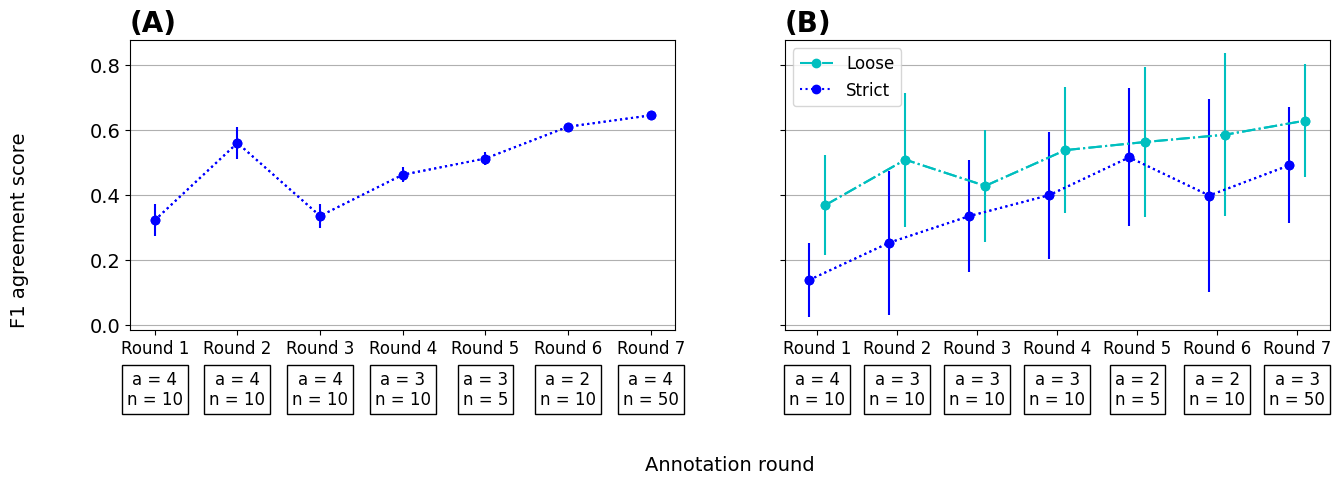

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,5))

x = np.arange(len(round_names))

ax1.plot(x, db_means,'bo:', label='Double-blind agreement')
ent_err_cont = ax1.errorbar(x, db_means, yerr=db_se, fmt='bo:')
ax1.set_xticks(x, round_names, size=12)
xtick_locs, xtick_labels = ax1.get_xticks(), ax1.get_xticklabels()
for xtick_loc, xtick_label in zip(xtick_locs, ann_num.keys()):
    ann_text = f'a = {ann_num[xtick_label]}'
    doc_text = f'n = {doc_num[xtick_label]}'
    box_text = f'{ann_text}\n{doc_text}'
    t = ax1.text(xtick_loc, -0.2, box_text, ha='center', va='center',
                 size=12, bbox=dict(boxstyle="square,pad=0.3", facecolor='white'))

ax2.plot(x + 0.1, db_rel_means_loose,'co-.', label='Loose')
rel_loose_err_cont = ax2.errorbar(x + 0.1, db_rel_means_loose, yerr=db_rel_se_loose, fmt='co-.')
ax2.plot(x - 0.1, db_rel_means_strict,'bo:', label='Strict')
rel_strict_err_cont = ax2.errorbar(x - 0.1, db_rel_means_strict, yerr=db_rel_se_strict, fmt='bo:')
ax2.set_xticks(x, rel_round_names, size=12)
ax2.legend(fontsize=12, loc='upper left')
xtick_locs, xtick_labels = ax2.get_xticks(), ax2.get_xticklabels()
for xtick_loc, xtick_label in zip(xtick_locs, ann_num.keys()):
    ann_text = f'a = {rel_ann_num[xtick_label]}'
    doc_text = f'n = {doc_num[xtick_label]}'
    box_text = f'{ann_text}\n{doc_text}'
    t = ax2.text(xtick_loc, -0.2, box_text, ha='center', va='center',
                 size=12, bbox=dict(boxstyle="square,pad=0.3", facecolor='white'))
ax1.grid(axis='y')
ax2.grid(axis='y')
ax1.set_title('(A)', fontsize='20', fontweight='bold', loc='left')
ax2.set_title('(B)', fontsize='20', fontweight='bold', loc='left')
fig.supylabel('F1 agreement score', fontsize=14)
fig.supxlabel('Annotation round', fontsize=14)
fig.subplots_adjust(bottom=0.3, left=0.1)


fig.savefig('../data/straying_off_topic_data/final_figures_PICKLE/figure_4.png', bbox_inches='tight', dpi=600)

### Check CI overlaps
Quantify which CIs overlap since it's hard to tell from the plot:

In [18]:
ent_intervs = defaultdict(list)
for pth in ent_err_cont.lines[2][0].get_paths():
    for seg in pth.iter_segments():
        ent_intervs[seg[0][0]].append(seg[0][1])
ent_intervs

defaultdict(list,
            {0.0: [0.2735, 0.3705],
             1.0: [0.511, 0.6090000000000001],
             2.0: [0.29900000000000004, 0.371],
             3.0: [0.4394833395016046, 0.4845166604983954],
             4.0: [0.4929474411167424, 0.5310525588832576],
             5.0: [0.61, 0.61],
             6.0: [0.633, 0.657]})

Round 7 errorbar doesn't overlap any of the other errorbars

In [19]:
rel_loose_intervs = defaultdict(list)
for pth in rel_loose_err_cont.lines[2][0].get_paths():
    for seg in pth.iter_segments():
        rel_loose_intervs[seg[0][0]].append(seg[0][1])
rel_loose_intervs

defaultdict(list,
            {0.1: [0.21393107360699357, 0.522882534708948],
             1.1: [0.3015404455948343, 0.7153443362899476],
             2.1: [0.25410616666154673, 0.6012390953170069],
             3.1: [0.34358314872072593, 0.7321518900861024],
             4.1: [0.33246266309508077, 0.7933309876985698],
             5.1: [0.3342312773217975, 0.8365262984357782],
             6.1: [0.45494891119789005, 0.8025121306320621]})

All visually and numerically overlap

In [20]:
rel_strict_intervs = defaultdict(list)
for pth in rel_strict_err_cont.lines[2][0].get_paths():
    for seg in pth.iter_segments():
        rel_strict_intervs[seg[0][0]].append(seg[0][1])
rel_strict_intervs

defaultdict(list,
            {-0.1: [0.02429470119237659, 0.2518528092625328],
             0.9: [0.03142632671911472, 0.4741947189019309],
             1.9: [0.16244484448003588, 0.5068497293618888],
             2.9: [0.2035643554109137, 0.5950051822304135],
             3.9: [0.3027432478925961, 0.7286059584566101],
             4.9: [0.10036395102420081, 0.6956966550364052],
             5.9: [0.3118158111869418, 0.670384555993101]})

Rounds 5 and 7 don't overlap with Round 1!